<a href="https://colab.research.google.com/github/Curiousss/EVA/blob/master/Phase2/Session1/Glove_Nlp8000FineTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

uploaded = files.upload()

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#!ls gdrive
#!rm aclImdb.zip
!ls

gdrive	sample_data


In [0]:
!unzip /content/gdrive/My\ Drive/Colab\ Notebooks/aclImdb.zip 

In [4]:
!wget "http://nlp.stanford.edu/data/glove.6B.zip"

--2020-01-22 15:27:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-22 15:27:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-22 15:27:29--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [5]:
!unzip glove.6B.zip
!ls

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
aclImdb  glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip  sample_data
gdrive	 glove.6B.200d.txt  glove.6B.50d.txt   __MACOSX


In [0]:
import os
import numpy as np

### Extracting the reviews and labels of the raw IMDB data

In [0]:
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

### Number of training sample = 8000

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
training_samples = 8000
validation_samples = 10000
max_words = 10000


Using TensorFlow backend.


## Tokenizer pre-processing
- Use tokenizer to get the unique words from the reviews. 
- Create the sequences of max length
- Shuffle the positive and negative reviews
- Split the training and validation data

In [9]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]


Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Get the precomputed embeddings downloaded from https://nlp.stanford.edu/projects/glove, 2014 English Wikipedia.
### Use 100-dimensional embedding vectors for 400,000 words (or nonword tokens)

In [10]:
glove_dir = ''
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
#print(len(train_data[3]), train_labels[3])


### Create embedding matrix of length max_words using the weight in the pretrained embedded index that was extracted from Glove 6B. Embedding dimension = 100

In [0]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

## Create the model
- Layer 1 - Embedding layer
- Layer 2 - Flatten
- Layer 3 Dense layer with Relu activation
- Layer 4 Dense layer with Sigmoid activation for classification

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the pretrained embedding layer weight for max_words.
### Fine tune the embedded layer.

In [13]:
model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable = False

## Compile and train the model for 10 epochs

In [14]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train,epochs=10,batch_size=32,validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 10000 samples
Epoch 1/10
8000/8000 [==============================] - 5s 651us/step - loss: 0.6700 - acc: 0.6175 - val_loss: 0.5721 - val_acc: 0.7169
Epoch 2/10
8000/8000 [==============================] - 5s 602us/step - loss: 0.4692 - acc: 0.7833 - val_loss: 0.4789 - val_acc: 0.7678
Epoch 3/10
8000/8000 [==============================] - 5s 621us/step - loss: 0.3058 - acc: 0.8690 - val_loss: 0.4820 - val_acc: 0.7754
Epoch 4/10
8000/8000 [==============================] - 5s 595us/step - loss: 0.2127 - acc: 0.9171 - val_loss: 0.7808 - val_acc: 0.7025
Epoch 5/10
8000/8000 [==============================] - 5s 592us/step - loss: 0.1314 - acc: 0.9500 - val_loss: 0.5896 - val_acc: 0.7745
Epoch 6/10
8000/8000 [==============================] - 5s 592us/step - loss: 0.0613 - acc: 0.9820 - val_loss: 0.6467 - val_acc: 0.7844
Epoch 7/10
8000/8000 [===============

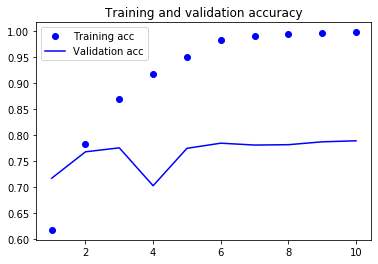

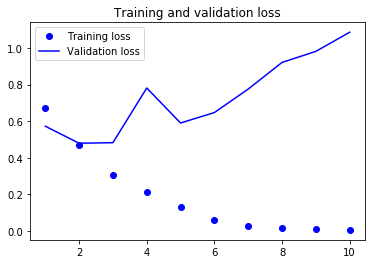

In [15]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # 1000, 16. Each word is mapped to an embedding vector.

(10000, 100)


In [17]:
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')
for word,i in word_index.items():
  print(word)
  if i == 10000:
    break
  #word_i = word_index[word]
  embeddings = weights[i]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

the
and
a
of
to
is
br
in
it
i
this
that
was
as
for
with
movie
but
film
on
not
you
are
his
have
he
be
one
all
at
by
an
they
who
so
from
like
her
or
just
about
it's
out
if
has
some
there
what
good
more
when
very
up
no
time
she
even
my
would
which
only
story
really
see
their
had
can
were
me
well
than
we
much
been
bad
get
will
do
also
into
people
other
first
great
because
how
him
most
don't
made
its
then
way
make
them
too
could
any
movies
after
think
characters
watch
two
films
character
seen
many
being
life
plot
never
acting
little
best
love
over
where
did
show
know
off
ever
does
better
your
end
still
man
here
these
say
scene
while
why
scenes
go
such
something
through
should
back
i'm
real
those
watching
now
though
doesn't
years
old
thing
actors
work
10
before
another
didn't
new
funny
nothing
actually
makes
director
look
find
going
few
same
part
again
every
lot
cast
us
quite
down
want
world
things
pretty
young
seems
around
got
horror
however
can't
fact
take
big
enough
long
thought
that's
bo

In [0]:
!cat vecs.tsv

-0.038194	-0.24487	0.72812	-0.39961	0.083172	0.043953	-0.39141	0.3344	-0.57545	0.087459	0.28787	-0.06731	0.30906	-0.26384	-0.13231	-0.20757	0.33395	-0.33848	-0.31743	-0.48336	0.1464	-0.37304	0.34577	0.052041	0.44946	-0.46971	0.02628	-0.54155	-0.15518	-0.14107	-0.039722	0.28277	0.14393	0.23464	-0.31021	0.086173	0.20397	0.52624	0.17164	-0.082378	-0.71787	-0.41531	0.20335	-0.12763	0.41367	0.55187	0.57908	-0.33477	-0.36559	-0.54857	-0.062892	0.26584	0.30205	0.99775	-0.80481	-3.0243	0.01254	-0.36942	2.2167	0.72201	-0.24978	0.92136	0.034514	0.46745	1.1079	-0.19358	-0.074575	0.23353	-0.052062	-0.22044	0.057162	-0.15806	-0.30798	-0.41625	0.37972	0.15006	-0.53212	-0.2055	-1.2526	0.071624	0.70565	0.49744	-0.42063	0.26148	-1.538	-0.30223	-0.073438	-0.28312	0.37104	-0.25217	0.016215	-0.017099	-0.38984	0.87424	-0.72569	-0.51058	-0.52028	-0.1459	0.8278	0.27062
-0.071953	0.23127	0.023731	-0.50638	0.33923	0.1959	-0.32943	0.18364	-0.18057	0.28963	0.20448	-0.5496	0.27399	0.58327	0.20468	-0.49228	0.19974

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
!cp *.tsv /content/gdrive/My\ Drive/Colab\ Notebooks/